In [1]:
# Instalación de open source solver glpk
#!apt install glpk-utils
#!pip install glpk
#!pip install pyomo 

In [2]:
# Importación de librerias
import random
import pandas as pd #manejo de datos
from pyomo.environ import * #optimización
from  pyomo import environ as pym
import matplotlib.pyplot as plt #Figuras
import numpy as np #Operaciones

In [3]:
# Creación del modelo 
model = ConcreteModel()

**Parámetros fijos**

Máxima potencia disponible de la red:
$$Max_{P_{G}}= 1500 \ kW$$
Máxima potencia disponible del generador Diésel de respaldo:
$$Max_{P_{D}}= 0 \ kW$$
Precio de adquisición de supercapacitor en usd por kWh:
$$SC_p = 2000 \ usd/kWh$$
Paso de simulación para el horizonte de tiempo:
$$t_s = 1 \ h$$


In [4]:
# Potencia máxima de transformador grid en kW
PGMax = 1500

# Potencia máxima disponible del generador diesel de respaldo
Pdiesel = 0

# Precio de adquisición de supercapacitor por Wh en usd/Wh
SC_price = 2

# Paso de simulación para el horizonte de tiempo en h
t_s = 1

#Reducción del costo de los almacenadores
Reduc_SC = 0.75

# Cargar datos de carga en kW
Ld = pd.read_excel('Data_Thesis.xlsx',sheet_name='CargaTodos',header=0,index_col=0)

# Cargar datos de irradiancia en W/m2
Gd = pd.read_excel('Data_Thesis.xlsx',sheet_name='Irradiance',header=0,index_col=0)
#Gd = Gd*0.8

# Cargar datos de temperatura ambiente en °C
Tem = pd.read_excel('Data_Thesis.xlsx',sheet_name='Temperature',header=0,index_col=0)

# Cargar datos de velocidad de viento en m/s
Wind = pd.read_excel('Data_Thesis.xlsx',sheet_name='Wind',header=0,index_col=0)

# Cargar información de disponibilidad de trafo grid
PGridAv = pd.read_excel('Data_Thesis.xlsx',sheet_name='GridAv',header=0,index_col=0)/1000

# Cargar datos de precio de energía $COP/kWh
Pusd = pd.read_excel('Data_Thesis.xlsx',sheet_name='PreciosTodos',header=0,index_col=0)

# Cargar datos de módulos PV
PVtype = pd.read_excel('Data_Thesis.xlsx',sheet_name='PVModules',header=0,index_col=0)

# Cargar datos de módulos de Batt y Batt+SC
Battype = pd.read_excel('Data_Thesis.xlsx',sheet_name='BattModules',header=0,index_col=0)

**Parámetros fijos**

tasa anual de interés e incremento del dinero para amortización:
$$t_{int} = 5 \%$$
Horizonte de planeación (vida útil del proyecto)
$$LY= 25 \ años$$

In [5]:
# Anualizar valores unitarios a 25 años (vida útil de paneles solares)
interest = 0.05
life_years = 25

# Coeficientes del VPN para todos los años del horizonte de planeación
VPN_F = [round(1/np.power(1+interest,i),3) for i in np.arange(1,life_years+1)]
# Suma de los coeficientes del VPN
VPN_FS = np.sum(VPN_F)


# PV
for x in range(0,len(PVtype.columns)):
    # Precio amortizado adquisición individual
    PVtype.iloc[7,x] = -1*np.pmt(interest, life_years, PVtype.iloc[0,x])
    # Precio amortizado instalación individual
    PVtype.iloc[8,x] = -1*np.pmt(interest, life_years, PVtype.iloc[1,x])

# Batt
Battprice = [0]*len(Battype.columns)
BattSCprice = [0]*len(Battype.columns)

for x in range(0,len(Battype.columns)):
    # Precio de una batería en el año 0
    Battprice[x] += Battype.iloc[0,x]
    # Precio de degradación en el año 0
    BattSCprice[x] += Battype.iloc[13,x]

for x in range(0,len(Battype.columns)):
    # Precio amortizado adquisición de una batería en el horizonte de planeación
    Battype.iloc[9,x]  = Battprice[x]
    Battype.iloc[10,x] = -1*np.pmt(interest, life_years, Battprice[x])
    Battype.iloc[14,x] = -1*np.pmt(interest, life_years, BattSCprice[x])

Battype[:].iloc[10] *= Reduc_SC      # Reducción en costos de adquisición almacenadores
Battype[:].iloc[14] *= Reduc_SC      # Reducción en costos de adquisición SC
Battype[:].iloc[0] *= Reduc_SC      # Reducción en costos de adquisición almacenadores
Battype[:].iloc[13] *= Reduc_SC      # Reducción en costos de adquisición SC

In [6]:
Battype

,Li-ion,VRLA,Li-ion + Sc,VRLA + SC
Descripcion,,,,
Costo Batería (usd),1370.880000,633.352500,1370.880000,633.352500
Capacidad E nom (kWh),3.552000,2.496000,3.552000,2.496000
Capacidad E inf (kWh),0.352000,0.499200,0.352000,0.499200
Capacidad E sup (kWh),3.552000,2.496000,3.552000,2.496000
Potencia descarga (kW),1.776000,0.024960,1.776000,0.024960
Potencia carga (kW),3.552000,1.236000,3.552000,1.236000
Eficiencia,0.950000,0.900000,0.950000,0.900000
Años útiles,15.000000,5.000000,15.000000,5.000000
Tensión (V),48.000000,12.000000,48.000000,12.000000


## Caso de estudio

In [7]:
Caso = 'UCI' # Elegir entre : 'Hospital' , 'Gobernacion' , 'Vichada'


if Caso == 'Hospital':

    Load = Ld['Carga_Hosp_C'].values

    PGridMax = PGridAv['CargaHosp'].values
    PDieselMax = PGridAv['CargaHospDiesel'].values
    MaxPpvG = 0.05*PGridAv['CargaHosp'].values  #0.05 por default        # Máxima potencia de venta de PV a la red W

    PriceENS = Pusd['PriceENS_Hosp'].values

    Cbackup = 0.53

    SoC_init = 1 #Estado de carga inicial

    Adisp = 3500                   # Área disponible para instalación de paneles solares en el lugar en m2

elif Caso == 'Gobernacion':

    Load = Ld['Carga_Gob'].values

    PGridMax = PGridAv['CargaGob'].values
    PDieselMax = PGridAv['CargaGobDiesel'].values
    MaxPpvG = 0.05*PGridAv['CargaGob'].values   #0.05 por default        # Máxima potencia de venta de PV a la red W
    PriceENS = Pusd['PriceENS_Gob'].values

    Cbackup = 0

    SoC_init = 1 #Estado de carga inicial

    Adisp = 350                  # Área disponible para instalación de paneles solares en el lugar en m2

elif Caso == 'UCI':

    Load = Ld['Carga_UCI'].values

    PGridMax = PGridAv['CargaHosp'].values
    PDieselMax = PGridAv['CargaHospDiesel'].values
    MaxPpvG = 0.05*PGridAv['CargaHosp'].values  #0.05 por default        # Máxima potencia de venta de PV a la red W

    PriceENS = Pusd['PriceENS_Hosp'].values

    Cbackup = 0.53

    SoC_init = 1 #Estado de carga inicial

    Adisp = 3500                   # Área disponible para instalación de paneles solares en el lugar en m2


elif Caso == 'Vichada':

    Load = Ld['Carga_Vichada'].values

    PGridMax = PGridAv['CargaVichada'].values
    PDieselMax = PGridAv['CargaVichadaDiesel'].values
    MaxPpvG = 0.05*PGridAv['CargaVichada'].values    #0.05 por default        # Máxima potencia de venta de PV a la red W
    PriceENS = Pusd['PriceENS_PC'].values

    Cbackup = 0

    SoC_init = 1 #Estado de carga inicial
    
    Adisp = 200                  # Área disponible para instalación de paneles solares en el lugar en m2

    
    


MaxBudget = 25000                      # Máximo presupuesto de inversión en el año cero
Ppvusd = 0.7*Pusd.loc[:,'PriceGrid']       # Costo deventa de energía solar a la red en $USD/kWh
MaxPayments = -1*np.pmt(interest, life_years, MaxBudget)  # Máximo presupuesto de inversión amortizado

PVDCstring = 1000             # Máxima tensión DC del arreglo FV 
Vdc = 48                     # Valor de tensión en el nodo DC de la microrred



In [8]:
Battype

,Li-ion,VRLA,Li-ion + Sc,VRLA + SC
Descripcion,,,,
Costo Batería (usd),1370.880000,633.352500,1370.880000,633.352500
Capacidad E nom (kWh),3.552000,2.496000,3.552000,2.496000
Capacidad E inf (kWh),0.352000,0.499200,0.352000,0.499200
Capacidad E sup (kWh),3.552000,2.496000,3.552000,2.496000
Potencia descarga (kW),1.776000,0.024960,1.776000,0.024960
Potencia carga (kW),3.552000,1.236000,3.552000,1.236000
Eficiencia,0.950000,0.900000,0.950000,0.900000
Años útiles,15.000000,5.000000,15.000000,5.000000
Tensión (V),48.000000,12.000000,48.000000,12.000000


In [9]:
PVtype

,Poly1,Mono1,Mono2
Descripcion,,,
Costo Panel (usd),126.000000,129.750000,138.500000
Costo instalacion (usd),219.500000,219.500000,219.500000
Area (m2),1.680000,1.940000,2.028000
Potencia (W) STC,345.000000,375.000000,390.000000
Potencia (W) NMOT,254.000000,280.700000,286.000000
Años utiles,25.000000,25.000000,25.000000
%deg/anual,0.625000,0.680000,0.500000
Costo Panel amort,8.940010,9.206081,9.826915
Costo instalacion amort,15.574064,15.574064,15.574064


Modelo de King de la temperatura del modulo fotovoltaico

$$ T_{m} = E·e^{a+b·WS}+T_{a} $$

Con la ecuación anterior se puede encontrar la temperatura de la superficie posterior del panel fotovoltaico a partir de la irradiancia, velocidad del viento y temperatura ambiente, en cada instante de tiempo. Los coeficientes a y b se encuentran de forma empírica ya que dependen de la instalación fisica de los paneles solares. La siguiente tabla muestra los coeficientes para diferentes formas de instalación:

<img src='Tabla_coef.PNG'>

Posteriormente, se encuentra la temperatura de operación del panel con la siguiente ecuación:

$$ T_{c} = T_{m}+\frac{E}{E_{0}}\Delta T $$


In [10]:
#Detemrnación de la emperatura del módulo a partir de datos meteorlógicos 
Tm = np.zeros(len(Wind))
for i in range(0,len(Wind)):
    Tm[i] = Gd['Irra_year'].values[i]*exp(-3.47-0.0594*Wind['vel (m/s)'].values[i])+Tem['Temperatura'].values[i]

T_panel = Tm+(Gd['Irra_year'].values/1000)*3

Para encontrar los nuevos valores de potencia MPP se utilizaron las siguientes ecuaciones

$$ P_{MPP} = P_{MPP,ref} \times (1+g(T-T_{ref}))\frac{S}{S_{ref}} $$

In [11]:
#Determinación de la potencia de MPPT para cada escenario meteorológico
n = pd.DataFrame(index=Gd.index,columns = PVtype.columns)
P_mpp = pd.DataFrame(index=Gd.index,columns = PVtype.columns)
P_in = pd.DataFrame(index=Gd.index,columns = PVtype.columns)

for k in list(PVtype.columns):
    
    P_mpp[k] = (PVtype.loc['Potencia (W) STC',k]*(1+(PVtype.loc['Tc_Pmax',k]/100)*(T_panel-25))*(Gd['Irra_year'].values/1000))/1000     
    P_in[k] = (Gd['Irra_year'].values*PVtype.loc['Area (m2)',k])/1000    
    a = P_mpp[k].values
    b = P_in[k].values
    n[k] = np.divide(a, b, out=np.zeros_like(a), where=b!=0)    
    

## Sets

In [12]:
# Sets
T= Ld.index.tolist() #LLamando los indices del dataframe
PVT= PVtype.columns.tolist() #LLamando los indices del dataframe
BATT= Battype.columns.tolist() #LLamando los indices del dataframe

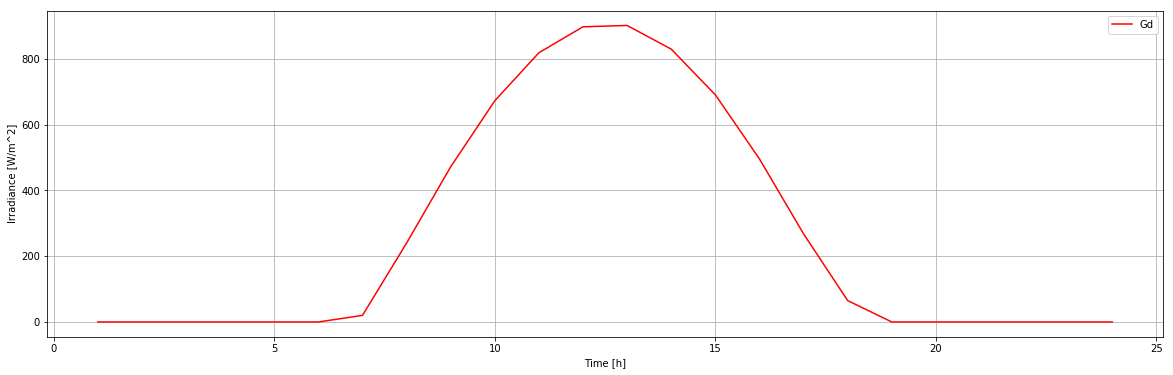

In [13]:
dia = 0 # de 0 a 364

Gdia = Gd.loc[(dia*24+1):(dia*24+24),'Irra_year']
Tdia = Gd.loc[(dia*24+1):(dia*24+24),'Irra_year'].index.tolist()

fig = plt.figure(figsize=(20,6))
plt.plot(Tdia,Gdia,'r',label='Gd')
plt.xlabel('Time [h]')
plt.ylabel('Irradiance [W/m^2]')
#plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23 , 24 ])
plt.legend()
plt.grid()
plt.show()
plt.close(fig)

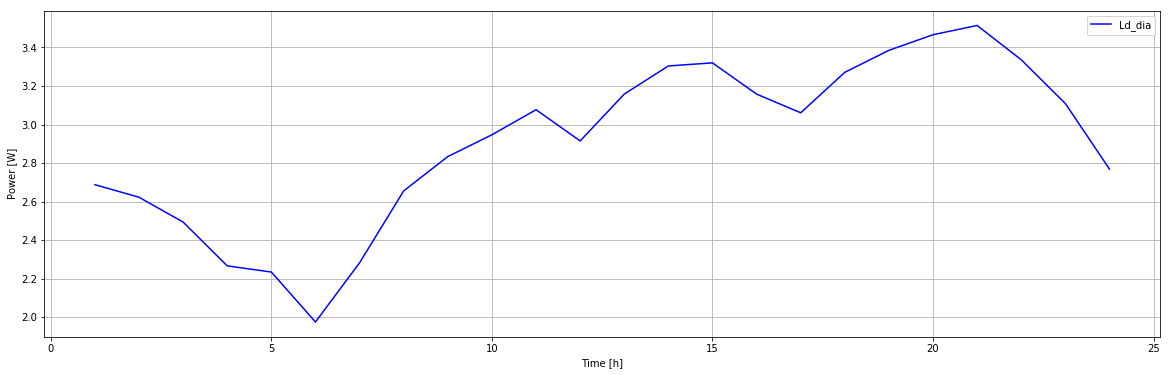

In [14]:
Ldia = Ld.loc[(dia*24+1):(dia*24+24),'Carga_Vichada']
Tdia = Ld.loc[(dia*24+1):(dia*24+24),'Carga_Vichada'].index.tolist()

fig = plt.figure(figsize=(20,6))
plt.plot(Tdia,Ldia,'b',label='Ld_dia')
plt.xlabel('Time [h]')
plt.ylabel('Power [W]')
#plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23 , 24 ])
plt.legend()
plt.grid()
plt.show()
plt.close(fig)

**Parámetros de entrada:**

**Parámetros fijos**

Máxima tensión del arreglo PV:
$$Max_{V_{PVstring}}= 1000 \ V_{dc}$$
tensión del nodo DC de la microrred:
$$V_{dc}= 48 \ V$$
Área disponible para instalación de paneles fotovoltaicos:
$$A_{disp}= 350 \ m^2$$
Máxima potencia fotovoltaica para venta a la red:
$$Max_{P_{PVG}} = 75000 \ W$$
Costo de venta de energía fotovoltaica a la red en pesos: 
$$C_{PVG}= 50 \ \$ $$
Costo de venta de energía fotovoltaica a la red en dolares:
$$C_{PVG} = usd_{cop} C_{PVG} $$
Máxima inversión para el sistema en el año 0 en dolares:
$$Max_{budget}=50000\ \$ $$
Máxima inversión para el sistema amortizada al horizonte de análisis:
$$Max_{payments}= 3547 \ \$ $$

**Parámetros que dependen del tipo de PV**

Costo unitario de panel solar en dólares:
$$C_{PV}$$
Costo unitario de intalación de panel solar en dólares:
$$C_{PVinst}$$
Área unitaria de cada panel fotovoltaico:
$$A_{PV}$$
Número máximo de paneles fotovoltaicos restringido por área:
$$AX_{PV} = A_{disp}/A_{PV}$$
Potencia unitaria de pánel fotovoltaico:
$$P_{PV_u}$$
Vida útil en años:
$$TPV_{ul}$$
Costo unitario de panel solar amortizado anualmente en dólares:
$$C_{PV_{y}}$$
Costo unitario de instalación de panel solar amortizado anualmente en dólares:
$$C_{PVinst_{y}}$$

**Parámetros que dependen del tipo de BATT**

Costo unitario de batería en dólares:
$$C_B $$
Capacidad energética unitaria de batería:
$$E_{Bu}$$
Energía mínima de batería:
$$E_{{Bu}_{inf}}$$
Energía máxima de batería:
$$E_{{Bu}_{sup}}$$
Potencia de carga/descarga mínima de batería:
$$P_{{Bu}_{inf}}$$
Potencia de carga/descarga máxima de batería:
$$P_{{Bu}_{sup}}$$
Eficiencia de carga y descarga de la batería:
$$\eta=\eta_d=\eta_c$$
Tensión de cada batería:
$$V_B$$
Vida útil en años:
$$TB_{ul}$$
Costo unitario de batería amortizado anualmente en dólares:
$$C_{B_{y}}$$
Número de ciclos de descarga en vida útil:
$$ND_{cyc}$$
Porcentaje de degradación de la capacidad de la batería por ciclo de descarga:
$$\% Deg$$


**Algunos otros parámetros propuestos para implementar:**

Tensión de las baterías para topología de bus DC:
$$V_B$$
Numero de descargas de las baterías para envejecimiento: 
$$n_d$$

**Variables del modelo:**

**Variables Discretas**

Número de paneles fotovoltaicos tipo A:
$$X_{PV_i}$$
Número de baterías tipo A:
$$X_{B_j}$$

**Variables Contínuas**

Potencia comprada a la red:
$$P_{G}$$
Potencia utilizada del generador Diésel de emergencia:
$$P_{D}$$
Potencia requerida por la energía no suministrada a la carga:
$$P_{ENS}$$
Potencia de paneles dirigida a la carga:
$$P_{PVL_i}$$
Potencia de paneles dirigida a la red:
$$P_{PVG_i}$$
Potencia de paneles dirigida a las baterías:
$$P_{PVB_ij}$$
Potencia de las baterías tipo dirigida a la carga:
$$P_{BL_j}$$
Potencia de las baterías:
$$P_{B_j}$$
Estado de carga de las baterías:
$$SoC_j$$
Capacidad de las baterías:
$$Bcap_j$$


**Variables Binarias**

Carga efectiva de las baterías:
$$Bc_j$$
Descarga efectiva de las baterías:
$$Bd_j$$

In [15]:
# Variables discretas
model.Xpvs  = Var(PVT, domain=NonNegativeIntegers)     # Número de strings de paneles solares
model.Xpv = Var(PVT, domain=NonNegativeIntegers)        # Número de paneles solares
model.XBb  = Var(BATT, domain=NonNegativeIntegers)      # Número de strings de Baterías
model.XB  = Var(BATT, domain=NonNegativeIntegers)       # Número de Baterías
model.Eps = Var(BATT, domain=NonNegativeReals)          # Reemplazo de baterías durante el periodo de análisis


# Variables continuas
model.PGL = Var(T, domain=NonNegativeReals)                              # Potencia de la red electrovichada a la carga
model.PGB = Var(BATT, T, domain=NonNegativeReals)                        # Potencia de la red electrovichada a la bateria
model.PD = Var(T, domain=NonNegativeReals)                               # Potencia del generador diésel de respaldo
model.ENS = Var(T, domain=NonNegativeReals)                              # Potencia para la energía no suministrada
model.PpvL = Var(PVT, T, domain=NonNegativeReals)                        # Potencia del panel dirigida a la carga
model.PpvG = Var(PVT, T, domain=NonNegativeReals)                        # Potencia del panel dirigida a la red
model.PpvB = Var(PVT, BATT, T, domain=NonNegativeReals)                  # Potencia del panel dirigida a las baterías A
model.PpvCur = Var(PVT, T, domain=NonNegativeReals)
model.PBL = Var(BATT, T, domain=NonNegativeReals)                        # Potencia de las baterías A dirigida a la carga
model.SoC = Var(BATT, T, domain=NonNegativeReals)                        # Estado de carga de las baterías tipo
model.Bcap = Var(BATT, T, domain=NonNegativeReals)                       # Capacidad de descarga de las baterías tipo


#Variables binarias/Toma de decisiones logicas (0,1)
model.Bceff = Var(BATT, T, within=Binary)                                # Carga efectiva de baterías con PV (1 = recibe Pot) (0 = no recibe pot)
model.BceffGrid = Var(BATT, T, within=Binary)                            # Carga efectiva de baterías con red (1 = recibe Pot) (0 = no recibe pot)
model.Bdeff = Var(BATT, T, within=Binary)                                # Descarga efectiva de baterías (1 = entrega pot) (0 = no entrega pot)


## Función objetivo

$$min \sum_{\forall i \in N}{(C^{PV}_{i}+C^{PVinst}_{i})X^{PV}_{i}} + \sum_{\forall j \in M}{C^{B}_{j}X^{B}_{j}} + \sum_{i=1}^{LY} \frac{1}{(1+r)^i} \left( \sum_{\forall j \in M}{\frac{C^{B}_{j}}{E^{B}_{j}}\epsilon^{B}_{j}} \right)
+ \sum_{i=1}^{LY} \frac{1}{(1+r)^i} \left( \sum_{\forall t \in T}{C^{grid}_t(P^{GL}_t + \sum_{\forall j \in M} P^{GB}_{j,t}) + C^{bckp}_t P^{D}_t + C^{ENS}_t P^{ENS}_t - C^{PVG}_t \sum_{\forall i \in N} P^{PVG}_{i,t}} \right) \delta T$$

In [16]:
#Función objetivo 
def obj_rule(model):#regla(Función python)
      return (sum(model.Xpv[tpv]*(PVtype[tpv].iloc[0]+PVtype[tpv].iloc[1]) for tpv in PVT) + 
              sum(model.XB[tbatt]*(Battype[tbatt].iloc[0]+Battype[tbatt].iloc[13]) + VPN_FS*model.Eps[tbatt]*((Battype[tbatt].iloc[0])/(0.2*Battype[tbatt].iloc[3])) for tbatt in BATT) + 
              VPN_FS*sum(Pusd.loc[t,'PriceGrid']*(model.PGL[t]+sum(model.PGB[tb,t] for tb in BATT)) + Cbackup*model.PD[t] + PriceENS[t-1]*model.ENS[t] - Ppvusd[t]*sum(model.PpvG[tpv,t] for tpv in PVT) for t in T))       

model.Obj=Objective(rule=obj_rule,sense=minimize)                  #Objetive=Objetive, minimizar función

## Restricciones

Cálculo de número de módulos por string:
$$X^{PV}_i = X^{PVs}_i \cdot \lfloor Max^{V_{PVstr}}/V^{oc_{u}}_i \rfloor \qquad \forall i \in N $$
Cálculo de número de baterías por banco:
$$X^{B}_j = X^{Bb}_j \cdot \lfloor Max^{V_B}/V^{B}_j \rfloor \qquad \forall j \in M$$
Maximo número de PV por área
$$ \sum_{\forall i \in N} A^{PV}_i X^{PV}_i \leq A^{av} $$

In [17]:
# Número de modulos FV del sistema por string
def PV_string_rule(model,tpv):#,t para todo t en T
    return model.Xpv[tpv] == model.Xpvs[tpv]*np.floor((PVDCstring/PVtype[tpv].iloc[9]))
model.PV_string=Constraint(PVT,rule=PV_string_rule)

# Número de baterías del sistema por string
def XB_bank_rule(model,tb):#,t para todo t en T
    return model.XB[tb] == model.XBb[tb]*np.floor(Vdc/Battype[tb].iloc[8])
model.XB_bank=Constraint(BATT,rule=XB_bank_rule)

#Maximo número de PV tipo
def PV_number_rule(model):#
    return sum(model.Xpv[tpv]*PVtype[tpv].iloc[2] for tpv in PVT) <= Adisp 
model.PV_number=Constraint(rule=PV_number_rule)

Máxima inversión económica posible en el año cero
$$\sum_{\forall i \in N}{(C^{PV}_i+C^{PVinst}_i)X^{PV}_i} + \sum_{\forall j \in M}{C^{B}_j X^{B}_j} \leq Max^{payments}  $$

In [18]:
#Restricción económica de la inversión
def Budget_rule(model):#
    return sum(model.Xpv[tpv]*(PVtype[tpv].iloc[7]+PVtype[tpv].iloc[8]) for tpv in PVT) + sum(model.XB[tbatt]*(Battype[tbatt].iloc[10]+Battype[tbatt].iloc[14]) for tbatt in BATT) <= MaxPayments
model.Budget=Constraint(rule=Budget_rule)

Balance de potencia:
$$P^{GL}_t + \sum_{\forall i \in N} P^{PVL}_{i,t} +\sum_{\forall j \in M} P^{BL}_{j,t} + P^{D}_t + P^{NS}_t = P^{L}_t \qquad \forall t \in T$$
Balance de potencia PV:
$$P^{PVL}_{i,t}+P^{PVG}_{i,t} + \sum_{\forall j \in M} P^{PVB}_{i,j,t} + P^{PVcur}_t = X^{PV}_i P^{mpp}_{i,t} \qquad \forall i \in N, \ \forall t \in T$$

In [19]:
#Balance de Potencia  
def P_balance_rule(model,t):#,t para todo t en T
    return model.PGL[t]+sum(model.PpvL[tpv,t] for tpv in PVT)+sum(model.PBL[tb,t] for tb in BATT)+model.PD[t]+model.ENS[t]== Load[t-1]
model.P_balance=Constraint(T,rule=P_balance_rule)

#Balance de Potencia PV 
def PV_balance_rule(model,tpv,t):#,t para todo t en T 
    return model.PpvL[tpv,t] + model.PpvG[tpv,t] + sum(model.PpvB[tpv,tb,t] for tb in BATT) + model.PpvCur[tpv,t] == model.Xpv[tpv]*P_mpp[tpv].iloc[t-1]
model.PV_balance=Constraint(PVT,T,rule=PV_balance_rule)

Restricción Potencia red:
$$P^{GL}_t + \sum_{\forall j \in M} P^{GB}_{j,t} \leq Max^{P_{G}} \cdot Grid^{av}_t \qquad \forall t \in T$$
Restricción Potencia Diesel:
$$P^{D}_t \leq Max^{P_{D}} \cdot Bckp^{av}_t \qquad \forall t \in T$$
Restricción Potencia PV de venta a red:
$$\sum_{\forall i \in N} P^{PVG}_{i,t} \leq Max^{P_{PVG}} \cdot Grid^{av}_t \qquad \forall t \in T$$

In [20]:
# Restricción Potencia red 
def PG_lim_rule(model,t):#
    return model.PGL[t] + sum(model.PGB[tb,t] for tb in BATT) <= PGridMax[t-1]
model.PG_lim=Constraint(T,rule=PG_lim_rule)

# Restricción Potencia diesel
def PD_lim_rule(model,t):#
    return model.PD[t] <= PDieselMax[t-1]
model.PD_lim=Constraint(T,rule=PD_lim_rule)

# Potencia PV de venta a red
def PpvG_lim_rule(model,t):#
    return sum(model.PpvG[tpv,t] for tpv in PVT) <= MaxPpvG[t-1]
model.PpvG_lim=Constraint(T,rule=PpvG_lim_rule)

Potencia de carga de baterías nominal para PV:
$$\sum_{\forall i \in N} P^{PVB}_{i,j,t} \leq X^{B}_j P^{Bu}_j \qquad \forall j \in M, \ \forall t \in T$$
Potencia de carga de baterías nominal para la Red:
$$P^{GB}_{j,t} \leq X^{B}_j P^{Bu}_j \qquad \forall j \in M, \ \forall t \in T$$
Potencia de descarga de baterías nominal:
$$P^{BL}_{j,t} \leq X^{B}_j P^{Bu}_j \qquad \forall j \in M, \ \forall t \in T$$

In [21]:
# Potencia PV de carga de baterías nominal
def PpvB_lim_rule(model,tb,t):#
    return sum(model.PpvB[tpv,tb,t] for tpv in PVT) <= model.Bcap[tb,t]/t_s
    #return sum(model.PpvB[tpv,tb,t] for tpv in PVT) <= model.XB[tb]*Battype[tb].iloc[5]
model.PpvB_lim=Constraint(BATT,T,rule=PpvB_lim_rule)

# Potencia Red de carga de baterías nominal
def PGB_lim_rule(model,tb,t):#
    return model.PGB[tb,t] <= model.Bcap[tb,t]/t_s
model.PGB_lim_rule=Constraint(BATT,T,rule=PGB_lim_rule)

# Potencia de descarga de la batería
def PBL_lims_rule(model,tb,t):#
    return model.PBL[tb,t] <= model.Bcap[tb,t]/t_s
    #return model.PBL[tb,t] <= model.XB[tb]*Battype[tb].iloc[4]
model.PBL_lims=Constraint(BATT,T,rule=PBL_lims_rule)

Batería cargando con PV:
$$\sum_{\forall i \in N} P^{PVB}_{i,j,t} \leq K \cdot B^{PVcs}_{j,t}$$
$$\sum_{\forall i \in N} P^{PVB}_{i,j,t} \geq -K \cdot (1-B^{PVcs}_{j,t}) $$
Batería cargando con Red:
$$P^{GB}_{j,t} \leq K \cdot B^{Gcs}_{j,t} $$
$$P^{GB}_{j,t} \geq -K \cdot (1-B^{Gcs}_{j,t}) $$
Batería descargando:
$$P^{BL}_{j,t} \leq K \cdot B^{ds}_{j,t}$$
$$P^{BL}_{j,t} \geq -K \cdot (1-B^{ds}_{j,t}) $$
Estado único de la batería
$$B^{PVcs}_{j,t} + B^{Gcs}_{j,t} + B^{ds}_{j,t} \leq 1 \qquad \forall j \in M, \ \forall t \in T$$

In [22]:
# Batería cargando con PV
def Ceff_rule1(model,tb,t):#
    return sum(model.PpvB[tpv,tb,t] for tpv in PVT) <= 100e6*model.Bceff[tb,t]
model.Ceff_rule1=Constraint(BATT,T,rule=Ceff_rule1)

def Ceff_rule2(model,tb,t):#
    return sum(model.PpvB[tpv,tb,t] for tpv in PVT) >= -100e6*(1-model.Bceff[tb,t])
model.Ceff_rule2=Constraint(BATT,T,rule=Ceff_rule2)

# Batería cargando con la red
def CeffGrid_rule1(model,tb,t):#
    return model.PGB[tb,t] <= 100e6*model.BceffGrid[tb,t]
model.CeffGrid_rule1=Constraint(BATT,T,rule=CeffGrid_rule1)

def CeffGrid_rule2(model,tb,t):#
    return model.PGB[tb,t] >= -100e6*(1-model.BceffGrid[tb,t])
model.CeffGrid_rule2=Constraint(BATT,T,rule=CeffGrid_rule2)

# Batería descargando
def Deff_rule1(model,tb,t):#
    return model.PBL[tb,t] <= 100e6*(model.Bdeff[tb,t])
model.Deff_rule1=Constraint(BATT,T,rule=Deff_rule1)

def Deff_rule2(model,tb,t):#
    return model.PBL[tb,t] >= -100e6*(1-model.Bdeff[tb,t])
model.Deff_rule2=Constraint(BATT,T,rule=Deff_rule2)

# Estado único de batería
def Bstate_rule(model,tb,t):#
    return model.Bceff[tb,t] + model.BceffGrid[tb,t] + model.Bdeff[tb,t] <= 1
model.Bstate_rule=Constraint(BATT,T,rule=Bstate_rule)

Estado de carga inicial de baterías
$$SoC_{j,t_0} = X^{B}_{j}E^{B}_{j}SoC^{init}_{j}$$
Capacidad inicial de baterías
$$B^{cap}_{j,t_0} = X^{B}_j E^{B}_j$$
Capacidad mínima de baterías 
$$SoC_{t,j} \geq X^{B}_{j}E^{{B}_{min}}_{j}$$
Capacidad máxima de baterías
$$SoC_{j,t} \leq B^{cap}_{j,t}$$

In [23]:
# Estado de carga inicial de baterías
def Batt_ini_rule(model,tb):#
    return model.SoC[tb,T[0]] == model.XB[tb]*Battype[tb].iloc[3]*SoC_init
model.Batt_ini=Constraint(BATT,rule=Batt_ini_rule)

# Capacidad inicial de las baterías
def Bcap_ini_rule(model,tb):#
    return model.Bcap[tb,1] == model.XB[tb]*Battype[tb].iloc[3]
model.Bcap_ini_rule=Constraint(BATT,rule=Bcap_ini_rule)

# Capacidad mínima de baterías 
def Batt_socmin_rule(model,tb,t):#
    return model.XB[tb]*Battype[tb].iloc[2] <= model.SoC[tb,t]
model.Batt_socmin=Constraint(BATT,T,rule=Batt_socmin_rule)

# Capacidad máxima de baterías 
def Batt_socmax_rule(model,tb,t):#
    return model.SoC[tb,t] <= model.Bcap[tb,t] 
model.Batt_socmax=Constraint(BATT,T,rule=Batt_socmax_rule)

Cálculo de estado de carga en baterías cada hora
$$SoC_{t,j} = SoC_{j,(t-1)}(1-SD^{B}_{j})+ \left( \sum_{\forall i \in N} P^{PVB}_{i,j,t} + P^{GB}_{j,t} \right) \delta T \eta - P^{BL}_{j,t}\delta T/\eta $$
Degradación de la capacidad de las baterías
$$B^{cap}_{j,t} = B^{cap}_{j,(t-1)} - Deg^{ESS}_j P^{BL}_{j,t}$$
Degradación anual de la capacidad de baterías
$$B^{cap}_{j,t_0}-B^{cap}_{j,t_f} = 0.2B^{cap}_{j,t_0}/LY + \epsilon^{B}_j$$

In [24]:
# Cálculo de estado de carga en baterías cada hora
def Batt_ts_rule(model,tb,t):#
    return (model.SoC[tb,t-1]*(1-(Battype[tb].iloc[15]))+sum(model.PpvB[tpv,tb,t]*(Battype[tb].iloc[6])*t_s for tpv in PVT) + 
            model.PGB[tb,t]*t_s*Battype[tb].iloc[6] - model.PBL[tb,t]*t_s/(Battype[tb].iloc[6])==model.SoC[tb,t])
model.Batt_ts=Constraint(BATT,T[1:-1],rule=Batt_ts_rule)

# Degradación de la capacidad de las baterías
def Bcap_rule1(model,tb,t):#
    return model.Bcap[tb,t] == model.Bcap[tb,t-1] - Battype[tb].iloc[12]*model.PBL[tb,t]
model.Bcap_rule1=Constraint(BATT,T[1:],rule=Bcap_rule1)

# Degradación anual de la capacidad de las baterías
def Bcap_rule2(model,tb):#
    return model.Bcap[tb,T[0]]-model.Bcap[tb,T[-1]] <= 0.2*model.Bcap[tb,T[0]]/life_years + model.Eps[tb]
model.Bcap_rule2=Constraint(BATT,rule=Bcap_rule2)

## Resolución del problema

In [ ]:
#import os

# provide an email address
#os.environ['NEOS_EMAIL'] = 'nmerchanr@unal.edu.co'

results=pym.SolverManagerFactory('neos').solve(model, opt='cplex')

#results=SolverFactory('cplex').solve(model, tee=True)
#results=SolverFactory('gurobi').solve(model, tee=True, keepfiles=True)

#results=SolverFactory('glpk').solve(model, tee=True)

In [ ]:
def pyomo_postprocess(options=None, instance=None, results=None):
    model.Obj.display()
    model.Xpv.display()
    model.Xpvs.display()
    model.XB.display()    
    model.Eps.display()    
    model.PBL.display()
    model.ENS.display()
    
pyomo_postprocess(None, model, results)

In [ ]:
model.Obj.display()

## Extracción de resultados

### 1) Variables indexadas por tipo de batería

In [ ]:
Bcap = []
PBL = []
SoC = []
PGB = []

Res_BATT = pd.DataFrame(columns=["Numero optimo","Strings"])

for b in BATT:
    Bcap.append([model.Bcap[b,t].value for t in T])
    PBL.append([model.PBL[b,t].value for t in T])    
    SoC.append([model.SoC[b,t].value for t in T])
    PGB.append([model.PGB[b,t].value for t in T])
    Res_BATT.loc[b] = [model.XB[b].value, model.XBb[b].value]
    
Res_BATT

### 2) Variables indexadas por tipo de panel

In [ ]:
PpvL = []
PpvG = []
PpvB = []
PpvCur = [sum(model.PpvCur[tpv,t].value for tpv in PVT) for t in T]

Res_PV = pd.DataFrame(columns=["Numero optimo","Strings"])
for pv in PVT:
    PpvL.append([model.PpvL[pv,t].value for t in T])
    PpvG.append([model.PpvG[pv,t].value for t in T])
    Res_PV.loc[pv] = [model.Xpv[pv].value, model.Xpvs[pv].value]
    for b in BATT:
        PpvB.append([model.PpvB[pv,b,t].value for t in T])

Res_PV

### 3) Variables indexadas por tiempo únicamente

In [ ]:
PGL=[model.PGL[t].value for t in T]
PD=[model.PD[t].value for t in T]
ENS=[model.ENS[t].value for t in T]

In [ ]:
fechas = pd.date_range(start = '01/01/2019 00:00', end='31/12/2019 23:00', freq='1H')

import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=fechas, y=Load,
                    mode='lines',
                    name='Load', line=dict(width=1, color='yellow')))


fig.add_trace(go.Scatter(
    x=fechas, y=PD,
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color='rgb(229, 180, 37)'),
    stackgroup='one',
    name='P_Diesel2Load'
))

fig.add_trace(go.Scatter(
    x=fechas, y=ENS,
    mode='lines',
    line=dict(width=0.5, color='rgb(0,0,0)'),
    stackgroup='one', # define stack group,
    name='ENS'
))

fig.add_trace(go.Scatter(
    x=fechas, y=PGL,
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.8, color='rgb(240, 109, 101)'),
    stackgroup='one',
    name='P_Grid2Load'
))
fig.add_trace(go.Scatter(
    x=fechas, y=np.sum(PBL, axis=0),
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color='rgb(101, 113, 240)'),
    stackgroup='one',
    name='P_Batt2Load'
))

fig.add_trace(go.Scatter(
    x=fechas, y=np.sum(PpvL, axis=0),
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color='rgb(101, 240, 113)'),
    stackgroup='one',
    name='P_PV2Load'
))



fig.update_layout(title_text='Distribución de la carga',
                  yaxis=dict(title='kW', titlefont_size=16, tickfont_size=14)
                 )
fig.show()

fig = go.Figure()

fig.add_trace(go.Scatter(x=fechas, y=(np.sum(SoC,axis=0)/np.sum(Bcap,axis=0))*100,
                    mode='lines',
                    name='SoC', line=dict(width=1, color='orange')))

fig.update_layout(title_text='Estado de carga de los almacenadores',
                  yaxis=dict(title='%', titlefont_size=16, tickfont_size=14)
                 )

fig.show()

In [ ]:
colors = ['red','blue','green','yellow','brown'] 
#colors[1] = 'crimson'
x=['Batt', 'PV', 'Grid', 'ENS', 'Diesel']
y = [np.sum(PBL), np.sum(PpvL), np.sum(PGL), np.sum(ENS), np.sum(PD)]

fig = go.Figure(data=[go.Bar(
    x=x,
    y=y,
    marker_color=colors, text=np.round(y),
    textposition='auto'# marker color can be a single color value or an iterable
)])
fig.update_layout(title_text='Distribución de la carga',
                  yaxis=dict(title='kWh', titlefont_size=16, tickfont_size=14))

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=fechas, y=PGL,
    mode='lines',
    line=dict(width=1, color='rgb(229, 180, 37)'),    
    name='P_Grid2Load'
))

fig.add_trace(go.Scatter(
    x=fechas, y=PGB,
    mode='lines',
    line=dict(width=1, color='rgb(101, 240, 113)'),
    name='P_Grid2Batt'
))


fig.update_layout(title_text='Distribución de la Red',
                  yaxis=dict(title='kW', titlefont_size=16, tickfont_size=14)
                 )
fig.show()

In [ ]:
colors = ['red','blue','green','yellow','brown'] 
#colors[1] = 'crimson'
x=['To Load', 'To Batt']
y = [np.sum(PGL), np.sum(PGB)]

fig = go.Figure(data=[go.Bar(
    x=x,
    y=y,
    marker_color=colors, text=np.round(y),
    textposition='auto'# marker color can be a single color value or an iterable
)])
fig.update_layout(title_text='Distribución de la Red',
                  yaxis=dict(title='kWh', titlefont_size=16, tickfont_size=14)
                 )

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=fechas, y=np.sum(PpvL, axis=0),
    mode='lines',
    line=dict(width=0.5, color='rgb(229, 180, 37)'),
    name='P_PV2Load'
))

fig.add_trace(go.Scatter(
    x=fechas, y=np.sum(PpvB, axis=0),
    mode='lines',
    line=dict(width=0.8, color='rgb(240, 109, 101)'),
    name='P_PV2Batt'
))
fig.add_trace(go.Scatter(
    x=fechas, y=np.sum(PpvG, axis=0),
    mode='lines',
    line=dict(width=0.5, color='rgb(101, 113, 240)'),
    name='P_PV2Grid'
))

fig.add_trace(go.Scatter(
    x=fechas, y=PpvCur,
    mode='lines',
    line=dict(width=0.7, color='green'),
    name='P_PV_Cur'
))


fig.update_layout(title_text='Distribución de la potencia fotovoltaica', yaxis=dict(title='kW', titlefont_size=16, tickfont_size=14))
fig.show()

In [ ]:
x=['To Load', 'To Batt', 'To Grid','Curtailment']
y = [np.sum(PpvL), np.sum(PpvB), np.sum(PpvG), np.sum(PpvCur)]

fig = go.Figure(data=[go.Bar(
    x=x,
    y=y,
    marker_color=colors, text=np.round(y),
    textposition='auto'# marker color can be a single color value or an iterable
)])
fig.update_layout(title_text='Distribución de la potencia fotovoltaica',
                  yaxis=dict(title='kWh', titlefont_size=16, tickfont_size=14)
                 )